# Smile detection (solución)

En este ejercicio crearemos una red neuronal para detectar si una persona está sonriendo o no. Para ello utilizaremos más de 13000 fotos de ejemplo.

1. Importar datos
2. Preprocesar datos
3. Visualización
4. Red neuronal
5. Entrenamiento
6. Resultados
7. Dropout
8. Balanceo de datos de entrenamiento
9. Predicción
10. Extra

## 1 - Importar datos
Los datos se encuentran dentro del mismo repositorio. Están ya clasificados en sonrisas (directorio 'positives') y no sonrisa (directorio 'negatives'). Los cargaremos a una variable llamada examples, etiquetando con un 1 las sonrisas y con un 0 las no sonrisas.

In [1]:
import glob
import numpy as np
from skimage.measure import block_reduce
from skimage.io import imread
import math
import PIL.Image
import IPython.display
import shutil
from io import BytesIO

np.random.seed(7)

positive_paths = glob.glob("positives/*.jpg")
negative_paths = glob.glob("negatives/*.jpg")
examples = [(path, 0) for path in negative_paths] + [(path, 1) for path in positive_paths]

In [2]:
#Verifico el total de los datos
len(examples)

13165

## 2 - Preprocesar datos
Para ganar en eficiencia reduciremos el tamaño de las fotos (investigar la función block_reduce) y normalizaremos los datos. Recordar que son imágenes en blanco y negro.

In [3]:
def examples_to_dataset(examples, block_size=2):
    X = []
    y = []
    for path, label in examples:
        img = imread(path, as_grey=True)
        img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
        X.append(img)
        y.append(label)
    return np.asarray(X), np.asarray(y)

%time X, y = examples_to_dataset(examples)
y = y.astype(np.int32)

CPU times: user 8.05 s, sys: 1.16 s, total: 9.21 s
Wall time: 10.5 s


** ¿Cómo se normaliza una imagen en blanco y negro? **

** Respuesta: ** Las imágenes tienen una única capa (versus las imágenes en color que tienen 3 capas para el rojo, azul y el verde) y los pixeles guardan la información del color en un número del 0 al 255. Se normaliza entre 0 y 1 dividiendo esta información entre 255.

In [4]:
### SOLUCIÓN
#Normalizar X
X = X.astype(np.float32) / 255.

## 3 - Visualización
Antes de continuar con el pre-procesamiento de los datos, visualizaremos algunos de los datos con los que entrenaremos.

In [5]:
def find_rectangle(n, max_ratio=2):
    sides = []
    square = int(math.sqrt(n))
    for w in range(square, max_ratio * square):
        h = n / w
        used = w * h
        leftover = n - used
        sides.append((leftover, (w, h)))
    return sorted(sides)[0][1]

def make_mosaic(images, n=None, nx=None, ny=None, w=None, h=None):
    if n is None and nx is None and ny is None:
        nx, ny = find_rectangle(len(images))
    else:
        nx = n if nx is None else nx
        ny = n if ny is None else ny
    images = np.array(images)
    if images.ndim == 2:
        side = int(np.sqrt(len(images[0])))
        h = side if h is None else h
        w = side if w is None else w
        images = images.reshape(-1, h, w)
    else:
        h = images.shape[1]
        w = images.shape[2]
    image_gen = iter(images)
    mosaic = np.empty((h*ny, w*nx))
    for i in range(ny):
        ia = (i)*h
        ib = (i+1)*h
        for j in range(nx):
            ja = j*w
            jb = (j+1)*w
            mosaic[ia:ib, ja:jb] = next(image_gen)
    return mosaic

def show_array(a, fmt='png', filename=None):
    a = np.squeeze(a)
    a = np.uint8(np.clip(a, 0, 255))
    image_data = BytesIO()
    PIL.Image.fromarray(a).save(image_data, fmt)
    if filename is None:
        IPython.display.display(IPython.display.Image(data=image_data.getvalue()))
    else:
        with open(filename, 'w') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)



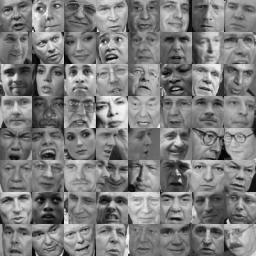

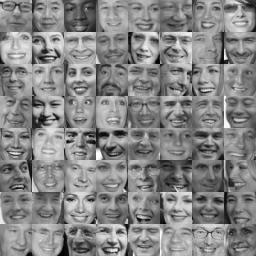

In [6]:
show_array(255 * make_mosaic(X[:len(negative_paths)], 8), fmt='jpeg') # negative at the beginning
show_array(255 * make_mosaic(X[-len(positive_paths):], 8), fmt='jpeg') # positive at the end

In [7]:
X = np.expand_dims(X, axis=-1)

In [8]:
from keras.utils import np_utils

Using TensorFlow backend.


Ahora transformaremos las etiquetas en categorías para facilitar el entrenamiento. 
- Una sonrisa está representada por un 1 pero queremos que sea [0,1]
- Una no sonrisa está representada por un 0 pero queremos que sea [1,0]

Esto nos posibilita a expandir el ejemplo y agregar más categorías en el futuro como enojado o sorprendido.

Luego aleatorizamos el orden de los ejemplos para poder separar sin sesgos los datos de validación, test y entrenamiento.

Utilizar la función np.utils.to_categorical para transformar y de su forma actual ([0 <font color=blue>0</font> 0 ..., <font color=red>1</font> 1 1]) en una matriz con la siguiente forma:
<br>
[[ 1.  0.]
<font color=blue>[ 1.  0.]</font><br>
 [ 1.  0.]<br>
 ...,
<font color=red>[ 0.  1.]</font><br>
 [ 0.  1.]<br>
 [ 0.  1.]]
 

In [9]:
print(y)
nb_classes = 2

[0 0 0 ..., 1 1 1]


In [10]:
### SOLUCIÓN
y = np_utils.to_categorical(y, nb_classes).astype(np.float32)

In [11]:
print(y)

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


** ¿Cómo se llama lo que acabamos de hacer con el vector y? **

** Respuesta: ** One hot encoding

In [12]:
# Aleatorizar el orden
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

print(X.dtype, X.min(), X.max(), X.shape)
print(y.dtype, y.min(), y.max(), y.shape)

float32 0.0 1.0 (13165, 32, 32, 1)
float32 0.0 1.0 (13165, 2)


In [13]:
### SOLUCIÓN
# Cantidad de caras sonriendo
y[y[:,1] == 1].sum()

3690.0

In [14]:
### SOLUCIÓN
# Cantidad de caras sin sonreir
y[y[:,0] == 1].sum()

9475.0

** ¿Cómo influirá tener más fotos de un tipo que del otro? **

** Respuesta: ** Probemos y veamos, el desbalance no es muy grande

## 4 - Red neuronal

** ¿Qué tipo de red neuronal nos conviene usar y por qué? **

** Respuesta: ** Convolutional neural networks porque estamos trabajando con imágenes. Las redes CNN manejan información espacial que aplica para el procesamiento de imágenes.

** ¿Qué parámetros específicos para este tipo de red hay que definir? **

** Respuesta: ** 
Cantidad de filtros por capa convolucional y Pool size para pooling layers. También hay que definir qué tipo de pooling hacemos (se sugiere comenzar probando con MaxPooling).
Luego hay que definir como en toda red la cantidad y orden de capas, funciones de activación, cantidad de nodos de capas densas, etc.

** ¿Cuántas nodos tendrá como output y por qué? **

** Respuesta: ** 2 nodos porque estamos clasificando imágenes con y sin sonrisa. Podría ser 1 también (interpretado como la probabilidad de que sonría).

** ¿Qué función de activación me conviene utilizar a la salida y por qué? **

** Respuesta: ** 
Conviene probar una activación de tipo softmax porque estamos resolviendo un problema de clasificación multiclase.

Crear una red neuronal que tenga las siguientes capas:
1. Capa convolucional con activación Relu
2. Capa convolucional con activación Relu
3. Capa de MaxPooling 
4. Capa de Flatten
5. Capa densa de 128 nodos con activación Relu
6. Capa densa para la salida con activación softmax

Compilar con función de pérdida categorical_crossentropy y optimizador adam.

In [15]:
### SOLUCIÓN
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D

#Cantidad de filtros por capa convolucional
nb_filters = 32
#Pool size
nb_pool = 2
#Stride
nb_conv = 3

model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=X.shape[1:]))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 812,770
Trainable params: 812,770
Non-trainable params: 0
_________________________________________________________________


## 5 - Entrenamiento

Entrenemos la red con un validation split de 10%, batch size de 128 y durante 5 epochs.

In [16]:
### SOLUCIÓN
validation_split = 0.10
model.fit(X, y, batch_size=128, epochs=5, verbose=1, validation_split=validation_split)

Train on 11848 samples, validate on 1317 samples
Epoch 1/5
11848/11848 [==============================] - 34s - loss: 0.4042 - acc: 0.8093 - val_loss: 0.3779 - val_acc: 0.8421
Epoch 2/5
11848/11848 [==============================] - 33s - loss: 0.2758 - acc: 0.8881 - val_loss: 0.2640 - val_acc: 0.8914
Epoch 3/5
11848/11848 [==============================] - 37s - loss: 0.2401 - acc: 0.9018 - val_loss: 0.2557 - val_acc: 0.9021
Epoch 4/5
11848/11848 [==============================] - 35s - loss: 0.2241 - acc: 0.9115 - val_loss: 0.2438 - val_acc: 0.9066
Epoch 5/5
11848/11848 [==============================] - 35s - loss: 0.2095 - acc: 0.9206 - val_loss: 0.2397 - val_acc: 0.9104


## 6 - Resultados
Analicemos la precisión que obtuvimos con nuestro entrenamiento.

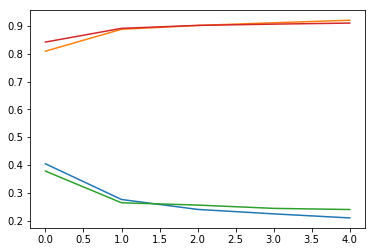

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(model.model.history.history['loss'])
plt.plot(model.model.history.history['acc'])
plt.plot(model.model.history.history['val_loss'])
plt.plot(model.model.history.history['val_acc'])
plt.show()

In [18]:
from sklearn.metrics import roc_auc_score
n_validation = int(len(X) * validation_split)
y_predicted = model.predict(X[-n_validation:])
print(roc_auc_score(y[-n_validation:], y_predicted))

0.953966549026


## 7 - Dropout

Analicemos el efecto del dropout en una red neuronal. 
Ahora creemos la siguiente red:
1. Capa convolucional con activación Relu
2. Capa convolucional con activación Relu
3. Capa de MaxPooling 
4. Capa de Dropout
5. Capa de Flatten
6. Capa densa de 128 nodos con activación Relu
7. Capa de Dropout
8. Capa densa para la salida con activación softmax

Compilar con función de pérdida categorical_crossentropy y optimizador adam.

** ¿Qué factor de dropout debo usar? **

** Respuesta: ** 
No hay una única respuesta válida, parámetro que se debe optimizar. Se recomienda comenzar a probar con 0.5

In [19]:
### SOLUCIÓN
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=X.shape[1:]))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               802944    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

Ahora entrenar la nueva red con las mismas condiciones que antes.

In [20]:
### SOLUCIÓN
model.fit(X, y, batch_size=128, epochs=5, verbose=1, validation_split=validation_split)

Train on 11848 samples, validate on 1317 samples
Epoch 1/5
11848/11848 [==============================] - 37s - loss: 0.5107 - acc: 0.7432 - val_loss: 0.3849 - val_acc: 0.8573
Epoch 2/5
11848/11848 [==============================] - 33s - loss: 0.3609 - acc: 0.8433 - val_loss: 0.3354 - val_acc: 0.8686
Epoch 3/5
11848/11848 [==============================] - 36s - loss: 0.3264 - acc: 0.8695 - val_loss: 0.3156 - val_acc: 0.8717
Epoch 4/5
11848/11848 [==============================] - 38s - loss: 0.2989 - acc: 0.8814 - val_loss: 0.3043 - val_acc: 0.8869
Epoch 5/5
11848/11848 [==============================] - 34s - loss: 0.2745 - acc: 0.8940 - val_loss: 0.2802 - val_acc: 0.8967


Analicemos los resultados nuevamente.

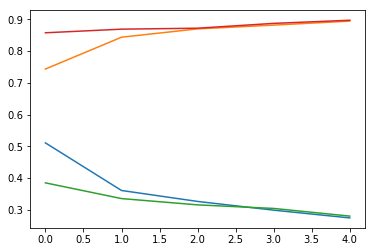

In [21]:
%matplotlib inline
plt.plot(model.model.history.history['loss'])
plt.plot(model.model.history.history['acc'])
plt.plot(model.model.history.history['val_loss'])
plt.plot(model.model.history.history['val_acc'])
plt.show()

In [22]:
n_validation = int(len(X) * validation_split)
y_predicted = model.predict(X[-n_validation:])
print(roc_auc_score(y[-n_validation:], y_predicted))

0.944871455076


## 8 - Balanceo de datos de entrenamiento
Habíamos observado antes que nuestros datos de entrenamiento están sesgados. Tratemos de compensar eso en nuestro entrenamiento. Utilizaremos el parámetro class_weight del método fit para ello.

La documentación oficial de Keras dice lo siguiente:
**class_weight** - Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.


In [23]:
# Preparo el argumento
class_totals = y.sum(axis=0)
class_weight = class_totals.max() / class_totals

Ahora entrenar la nueva red con las mismas condiciones que antes.

In [24]:
### SOLUCIÓN
model.fit(X, y, batch_size=128, class_weight=class_weight, epochs=5, verbose=1, validation_split=validation_split)

Train on 11848 samples, validate on 1317 samples
Epoch 1/5
11848/11848 [==============================] - 34s - loss: 0.2562 - acc: 0.8995 - val_loss: 0.2574 - val_acc: 0.9036
Epoch 2/5
11848/11848 [==============================] - 40s - loss: 0.2481 - acc: 0.9020 - val_loss: 0.2522 - val_acc: 0.9066
Epoch 3/5
11848/11848 [==============================] - 37s - loss: 0.2383 - acc: 0.9058 - val_loss: 0.2522 - val_acc: 0.9066
Epoch 4/5
11848/11848 [==============================] - 35s - loss: 0.2284 - acc: 0.9122 - val_loss: 0.2457 - val_acc: 0.9036
Epoch 5/5
11848/11848 [==============================] - 32s - loss: 0.2144 - acc: 0.9160 - val_loss: 0.2380 - val_acc: 0.9081


Analicemos los resultados nuevamente.

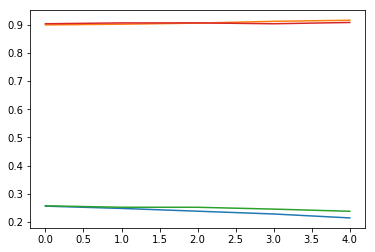

In [25]:
%matplotlib inline
plt.plot(model.model.history.history['loss'])
plt.plot(model.model.history.history['acc'])
plt.plot(model.model.history.history['val_loss'])
plt.plot(model.model.history.history['val_acc'])
plt.show()

In [26]:
n_validation = int(len(X) * validation_split)
y_predicted = model.predict(X[-n_validation:])
print(roc_auc_score(y[-n_validation:], y_predicted))

0.955878332194


## 9 - Predicción
Una vez que estoy satisfecho con mi modelo puedo comenzar a usarlo para predecir.

In [27]:
def print_indicator(data, model, class_names, bar_width=50):
    probabilities = model.predict(np.array([data]))[0]
    print(probabilities)
    print(class_names[0], class_names[1])

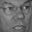

[ 0.9919315   0.00806852]
NoSonrisa Sonrisa


In [28]:
class_names = ['NoSonrisa', 'Sonrisa']
img = X[-7]
show_array(255 * img)
print_indicator(img, model, class_names)

In [ ]:
class_names = ['NoSonrisa', 'Sonrisa']
img = X[-25]
show_array(255 * img)
print_indicator(img, model, class_names)

In [ ]:
class_names = ['NoSonrisa', 'Sonrisa']
img = X[-254]
show_array(255 * img)
print_indicator(img, model, class_names)

## 10 - Extra
Jugar ahora con otros parámetros, volver a entrenar la red y ver si es posible aumentar la precisión.

In [ ]:
#Cantidad de filtros por capa convolucional
nb_filters = 32
#Pool size
nb_pool = 2
#Stride
nb_conv = 3

....